In [1]:
#zwykła konwolucyjna sieć - obrazek czas x czestosc, kanały RGB - elektrody - przetestować
#CONV2D, minpooling potem, dense (f-cja aktywacji softmax) - wyjscie to p-stwo wyjscia z klas
#punkt początkowy j.w.
#filtr dla sieci - dłuższy w czasie (np. 7,11), najwyżej dociać
#zbiory uczące - potem będziemy składać sieci
#zbiory - 2 sposoby jak je budować (od Mateusza)
#widmo - spr do jakiej częstości obciąć (z tego co wychodzi z abs hilberta), 6 razy mniej (?)
#kilka próbek od kilku pacjentów

#wyćwiczone na wszystkich - wyzerować któreś i tak sprawdzić (pasmo częstowściowe)


In [2]:
''' 25 na 5 foldów - 5x5 średnie acc, auc
    8 walidacyjnych zostaje
    5 różnych modeli - dla każddego z osobna walidacja
    jesli więcej niż 3 modele na daną klase - zaklasyfikowany - policzyć accuracy,
    wykresy acc w czasie i loss w czasie dla każdej z 5 (25 na 5 foldów) modeli (w każdej iteracji),
    sprawadź dla paru batch size jak sie zachowują wykresy,
    '''

' 25 na 5 foldów - 5x5 średnie acc, auc\n    8 walidacyjnych zostaje\n    5 różnych modeli - dla każddego z osobna walidacja\n    jesli więcej niż 3 modele na daną klase - zaklasyfikowany - policzyć accuracy,\n    wykresy acc w czasie i loss w czasie dla każdej z 5 (25 na 5 foldów) modeli (w każdej iteracji),\n    sprawadź dla paru batch size jak sie zachowują wykresy,\n    '

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from typing import Iterable, Union
from numpy.random import seed
seed(2020)
from tensorflow import set_random_seed
set_random_seed(2020)

In [6]:
def get_training(X, y, combinations):
    X_train = np.concatenate([X[ind] for ind in combinations], axis = 1)
    X_train = np.einsum('ijkl->jlik', X_train)
    y_train = np.concatenate([y[ind] for ind in combinations])
    y_train = to_categorical(y_train).astype(int)
    return X_train, y_train

def get_test(X, y, ind):
    X_test = np.einsum('ijkl->jlik',X[ind])
    y_test = to_categorical(y[ind]).astype(int)
    return X_test, y_test



In [40]:
def evaluate(model, X_val: Iterable, y_val: Iterable, verbose = 1):
    # Generate generalization metrics
    score = model.evaluate(X_val, y_val, verbose=0)
    if verbose:
        print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
    return score

def plot_history(history, loss_fun: str):
    # Plot history: Categorical crossentropy & Accuracy
    plt.figure(figsize=(12,8))
    plt.plot(history.history['loss'], label=loss_fun + '(training data)')
    plt.plot(history.history['val_loss'], label=loss_fun + '(validation data)')
    plt.plot(history.history['acc'], label='Accuracy (training data)')
    plt.plot(history.history['val_acc'], label='Accuracy (validation data)')
    plt.title('Model performance')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()

In [39]:
def create_model(sample_shape: Iterable,
                 no_classes: int, 
                 loss_fun = 'binary_crossentropy'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size = (11,1),input_shape=sample_shape, activation='relu', data_format = 'channels_last'))
    model.add(AveragePooling2D((11,1)))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='softmax'))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(no_classes, activation='softmax'))
    model.compile(loss=loss_fun, optimizer='adam', metrics=['accuracy'])
    return model

def fit(model, X_train: Iterable, y_train: Iterable, 
                      X_test: Iterable, y_test: Iterable,
                      batch_size: int, no_epochs: int, 
                      verbosity = 1):
    
    # Fit data to model
    history = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity,
                validation_data=(X_test, y_test))
    return model, history

# Loading data

In [3]:
class_no8 = np.load('class_no8.npy')
data_no8 = np.load('data_no8.npy')


class_no13 = np.load('class_no13.npy')
data_no13 = np.load('data_no13.npy')

class_no18 = np.load('class_no18.npy')
data_no18 = np.load('data_no18.npy')

class_no23 = np.load('class_no23.npy')
data_no23 = np.load('data_no23.npy')

class_no28 = np.load('class_no28.npy')
data_no28 = np.load('data_no28.npy')

class_no33 = np.load('class_no33.npy')
data_no33 = np.load('data_no33.npy')

### Validation dataset

In [4]:
X_validation = np.einsum('ijkl->jlik',data_no8)
y_validation = to_categorical(class_no8).astype(int)

(7285, 77, 5, 19)


(7285, 2)

## Prepared combinations

In [5]:
X = {1 : data_no13, 2: data_no18, 3: data_no23, 4: data_no28, 5: data_no33}
y = {1 : class_no13, 2: class_no18, 3: class_no23, 4: class_no28, 5: class_no33}
combinations_train = ((1,2,3,4),
                      (1,2,3,5),
                      (1,2,4,5),
                      (1,3,4,5),
                      (2,3,4,5))

combinations_test = (5, 4, 3, 2, 1)

### Params

In [43]:
batch_size = 200
no_epochs = 30
verbosity = 1
loss_fun = 'categorical_crossentropy'

## Datasets

In [44]:
combination = 1
X_train, y_train = get_training(X, y, combinations_train[combination])
X_test, y_test = get_test(X, y, combinations_test[combination])
sample_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

## Learning

In [45]:
"Creating model"
model = create_model(sample_shape, 2)

"Fitting model to data"
fitted_model, hist = fit(model, X_train, y_train, X_test, y_test, 
            batch_size, no_epochs)

Train on 18144 samples, validate on 4618 samples
Epoch 1/30
18144/18144 [==============================] - 3s 154us/sample - loss: 0.6927 - acc: 0.5118 - val_loss: 0.6898 - val_acc: 0.5351
Epoch 2/30
18144/18144 [==============================] - 2s 135us/sample - loss: 0.6888 - acc: 0.5385 - val_loss: 0.6865 - val_acc: 0.5457
Epoch 3/30
18144/18144 [==============================] - 2s 134us/sample - loss: 0.6851 - acc: 0.5527 - val_loss: 0.6846 - val_acc: 0.5580
Epoch 4/30
18144/18144 [==============================] - 2s 137us/sample - loss: 0.6825 - acc: 0.5606 - val_loss: 0.6836 - val_acc: 0.5528
Epoch 5/30
18144/18144 [==============================] - 2s 133us/sample - loss: 0.6802 - acc: 0.5681 - val_loss: 0.6822 - val_acc: 0.5608
Epoch 6/30
18144/18144 [==============================] - 2s 135us/sample - loss: 0.6785 - acc: 0.5666 - val_loss: 0.6813 - val_acc: 0.5663
Epoch 7/30
18144/18144 [==============================] - 2s 135us/sample - loss: 0.6780 - acc: 0.5724 - val_lo

## Evaluating

Test loss: 0.6789426702297789 / Test accuracy: 0.5630748271942139


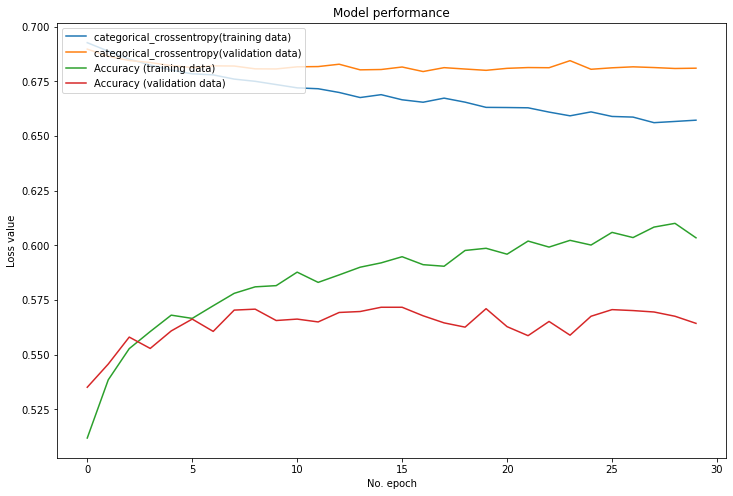

In [46]:
"Getting validation and loss score"
score = evaluate(fitted_model, X_validation, y_validation)

"Plotting history"
plot_history(hist, loss_fun)

## Collecting votes

In [49]:
batch_size = 200
no_epochs = 10

trials = y_validation.shape[0]
pred = np.zeros((5,trials))

for i in range(5):
    X_train, y_train = get_training(X, y, combinations_train[i])
    X_test, y_test = get_test(X, y, combinations_test[i])
    sample_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
    model = create_model(sample_shape, 2)
    fitted_model, _ = fit(model, X_train, y_train, X_test, y_test, 
                batch_size, no_epochs)
    pred[i] = fitted_model.predict_classes(X_validation)

votes = np.sum(pred, axis = 0)
votes[votes<=2] = 0
votes[votes>=3] = 1
score = len(votes[class_no8==votes])

Train on 18090 samples, validate on 4672 samples
Epoch 1/10
18090/18090 [==============================] - 3s 157us/sample - loss: 0.6920 - acc: 0.5159 - val_loss: 0.6891 - val_acc: 0.5402
Epoch 2/10
18090/18090 [==============================] - 3s 139us/sample - loss: 0.6882 - acc: 0.5416 - val_loss: 0.6881 - val_acc: 0.5415
Epoch 3/10
18090/18090 [==============================] - 3s 139us/sample - loss: 0.6855 - acc: 0.5516 - val_loss: 0.6865 - val_acc: 0.5477
Epoch 4/10
18090/18090 [==============================] - 2s 136us/sample - loss: 0.6832 - acc: 0.5600 - val_loss: 0.6859 - val_acc: 0.5501
Epoch 5/10
18090/18090 [==============================] - 2s 137us/sample - loss: 0.6797 - acc: 0.5705 - val_loss: 0.6855 - val_acc: 0.5619
Epoch 6/10
18090/18090 [==============================] - 2s 137us/sample - loss: 0.6785 - acc: 0.5704 - val_loss: 0.6852 - val_acc: 0.5578
Epoch 7/10
18090/18090 [==============================] - 2s 135us/sample - loss: 0.6763 - acc: 0.5782 - val_lo

In [51]:
print(score/trials)

0.5652711050102951
